In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.applications import MobileNet
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
os.chdir('../input/face-expression-recognition-dataset/images/')
train_path = './train/'
validation_path = './validation/'
os.listdir()

['validation', 'train', 'images']

# Displaying images from the training directory

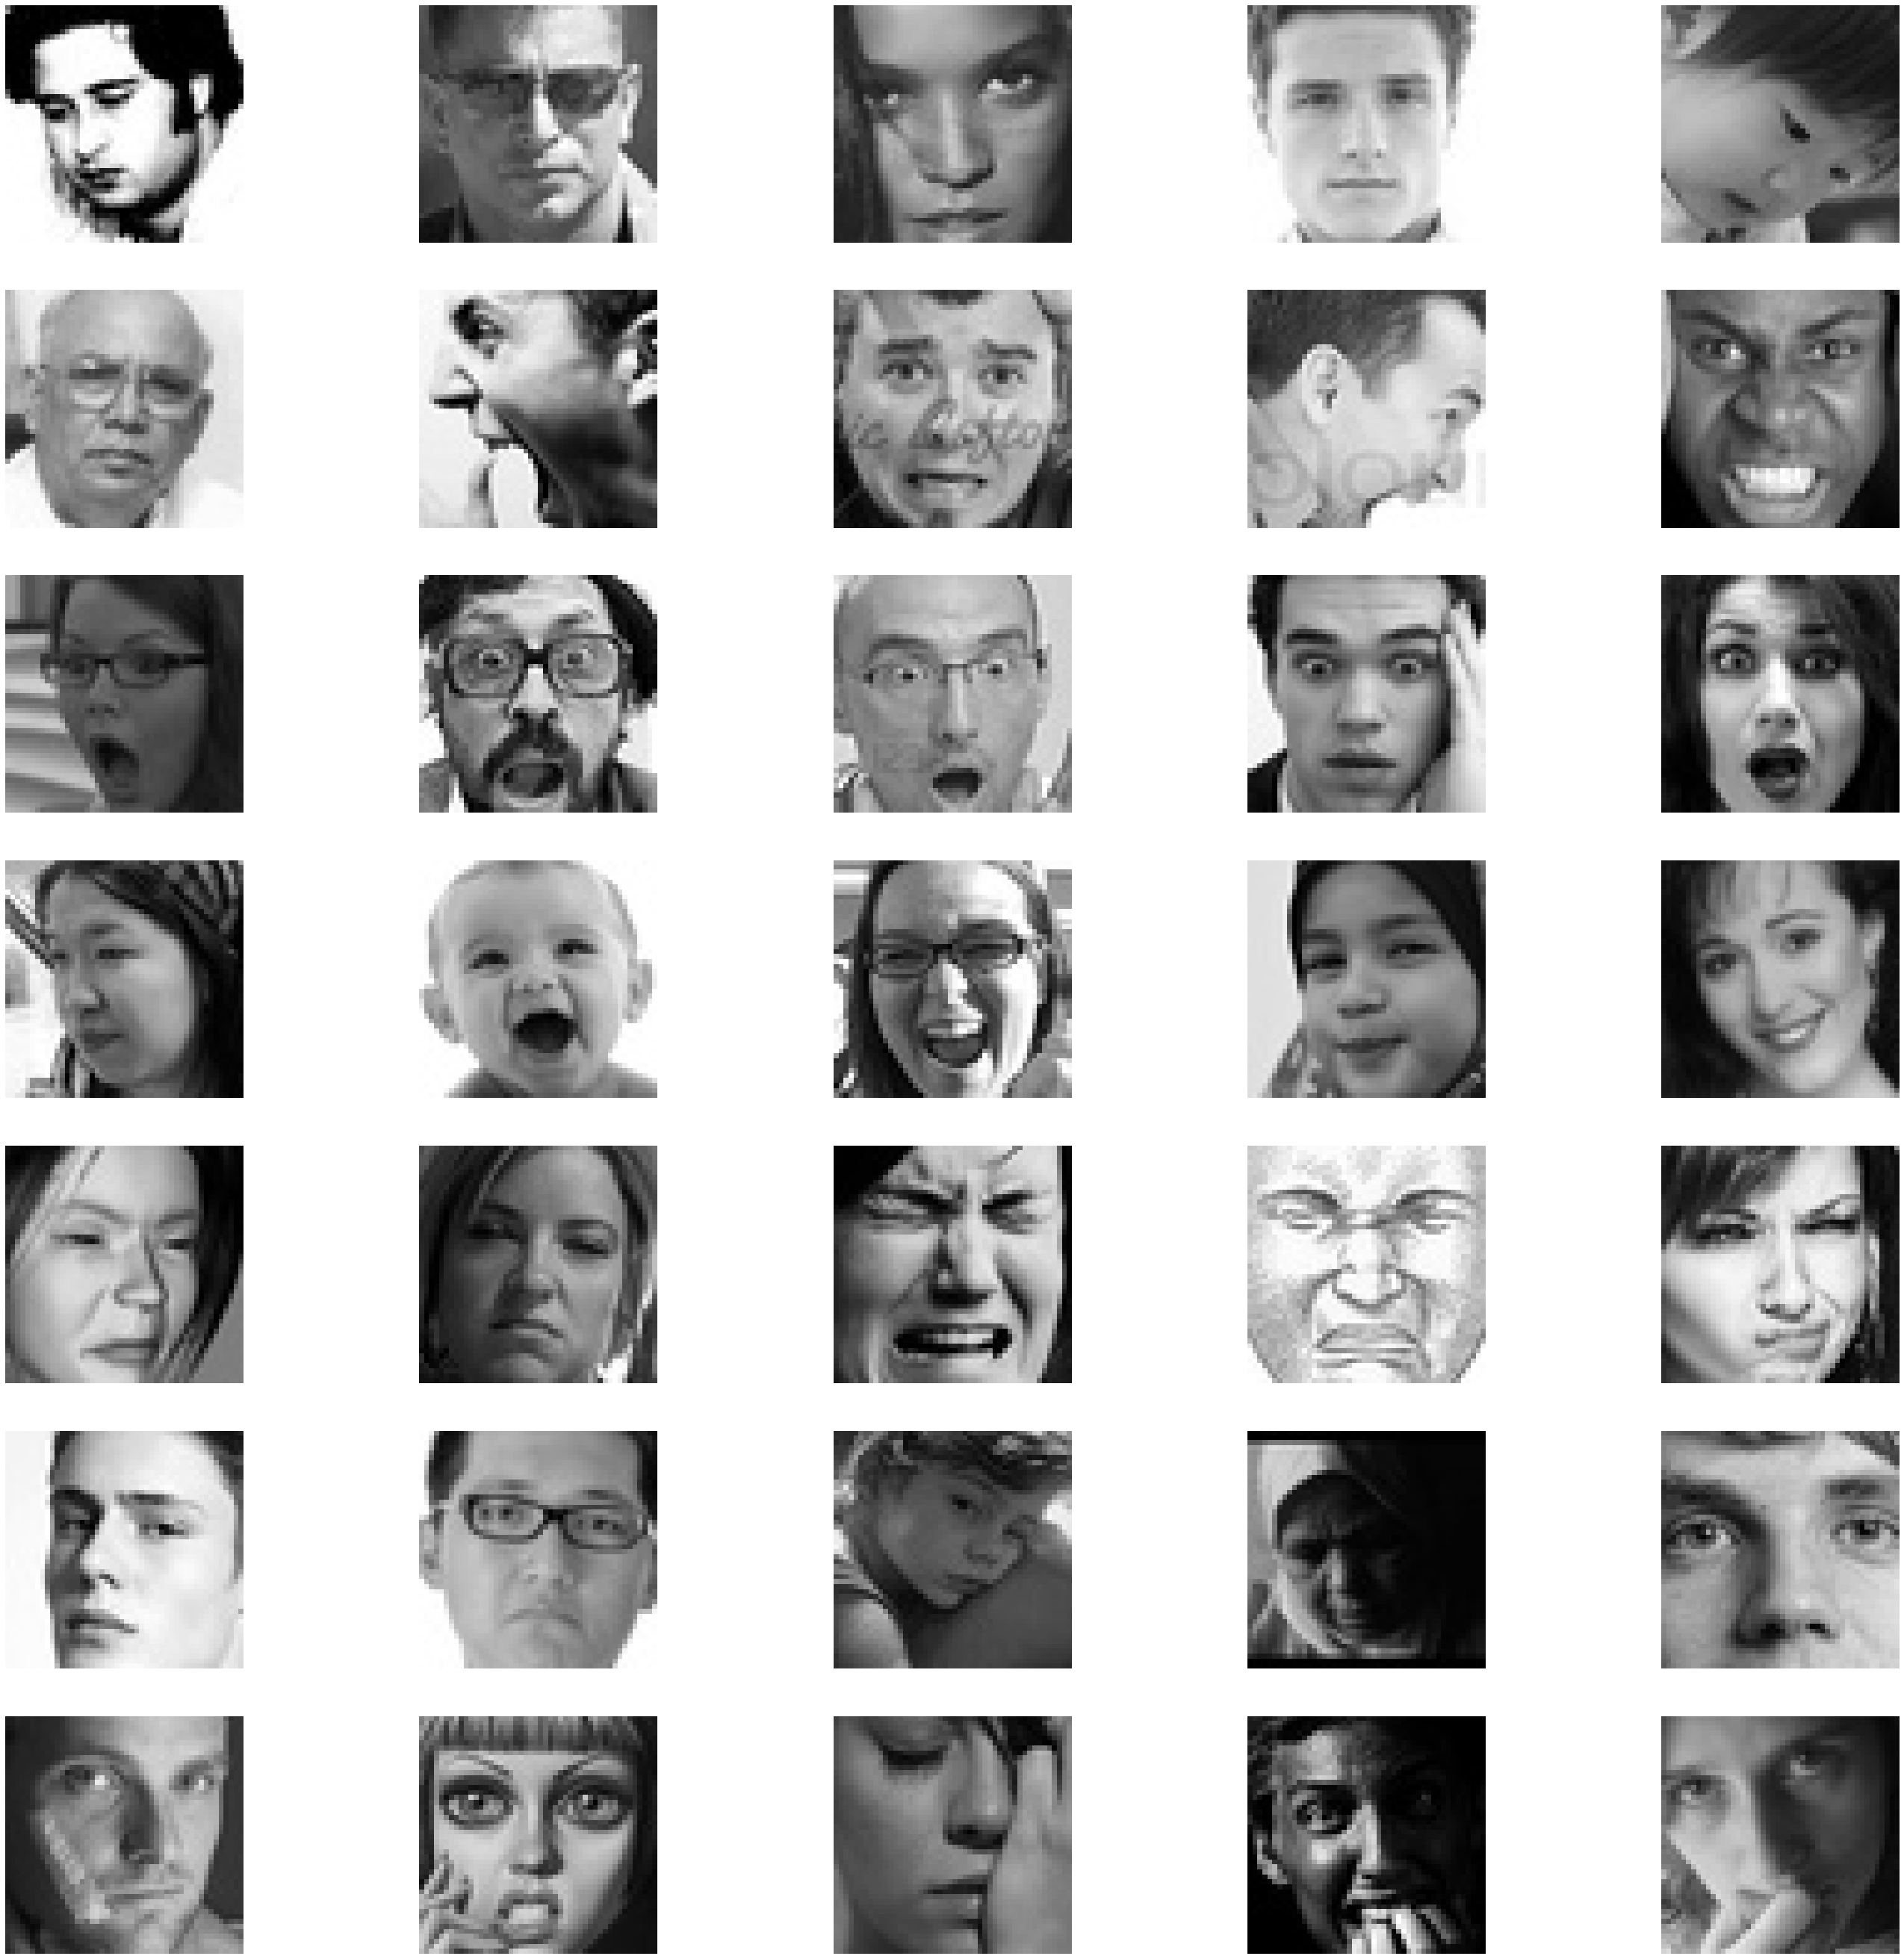

In [3]:
plt.figure(0, figsize=(48,48))
cpt = 0

for expression in os.listdir(train_path):
    for i in range(1,6):
        cpt = cpt + 1
        sp=plt.subplot(7,5,cpt)
        sp.axis('Off')
        img_path = train_path + expression + "/" +os.listdir(train_path + expression)[i]
        img = load_img( img_path, target_size=(48,48))
        plt.imshow(img, cmap="gray")


plt.show()

# Data Generators

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   zoom_range=0.2)

validation_datagen = ImageDataGenerator(rescale=1/255)

batch_size = 128


train_generator = train_datagen.flow_from_directory (train_path,   
                                                     target_size=(48, 48),  
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     class_mode='categorical',
                                                     color_mode="rgb")


validation_generator = validation_datagen.flow_from_directory(validation_path,  
                                                              target_size=(48,48), 
                                                              batch_size=batch_size,
                                                              class_mode='categorical',
                                                              color_mode="rgb")


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Building Our Model

In [5]:
#Loading the Mobilenet model 
featurizer = MobileNet(include_top=False, weights='imagenet', input_shape=(48,48,3))

#Since we have 7 types of expressions, we'll set the nulber of classes to 7
num_classes = 7

#Adding some layers to the feturizer
x = Flatten()(featurizer.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(num_classes, activation = 'softmax')(x)



model = Model(input = featurizer.input, output = predictions)


model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 49, 49, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 24, 24, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 24, 24, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)        288       
____________________________________________________________

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


# Training 
Callbacks : we'll use **ModelCheckpoint**, which allows us to save our model's weights, and by setting **save_best_only** parameter to true, the latest best model according to the quantity monitored (which is val_accuracy here) won't be overwritten. Our **mode** parameter is set to max because we want the val_accuracy to be the highest. 

In [6]:
model_weights_path = r'/kaggle/working/model_weights.h5'

checkpoint = ModelCheckpoint(model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history = model.fit(train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        validation_steps=validation_generator.n//validation_generator.batch_size,
                        epochs=40,
                        verbose=1,
                        validation_data = validation_generator,
                        callbacks=[checkpoint])

Epoch 1/40
225/225 [==============================] - 317s 1s/step - loss: 1.8817 - accuracy: 0.3401 - val_loss: 1.6699 - val_accuracy: 0.4178

Epoch 00001: val_accuracy improved from -inf to 0.41776, saving model to /kaggle/working/model_weights.h5
Epoch 2/40
225/225 [==============================] - 312s 1s/step - loss: 1.4381 - accuracy: 0.4601 - val_loss: 2.1395 - val_accuracy: 0.3946

Epoch 00002: val_accuracy did not improve from 0.41776
Epoch 3/40
225/225 [==============================] - 305s 1s/step - loss: 1.3090 - accuracy: 0.5050 - val_loss: 1.6582 - val_accuracy: 0.4912

Epoch 00003: val_accuracy improved from 0.41776 to 0.49121, saving model to /kaggle/working/model_weights.h5
Epoch 4/40
225/225 [==============================] - 308s 1s/step - loss: 1.2263 - accuracy: 0.5395 - val_loss: 1.2003 - val_accuracy: 0.5477

Epoch 00004: val_accuracy improved from 0.49121 to 0.54771, saving model to /kaggle/working/model_weights.h5
Epoch 5/40
225/225 [=========================

# Saving Our Model

In [7]:
# serialize model to JSON
model_json = model.to_json()
with open(r'/kaggle/working/model.json', "w") as json_file:
    json_file.write(model_json)

# Accuracy & Loss

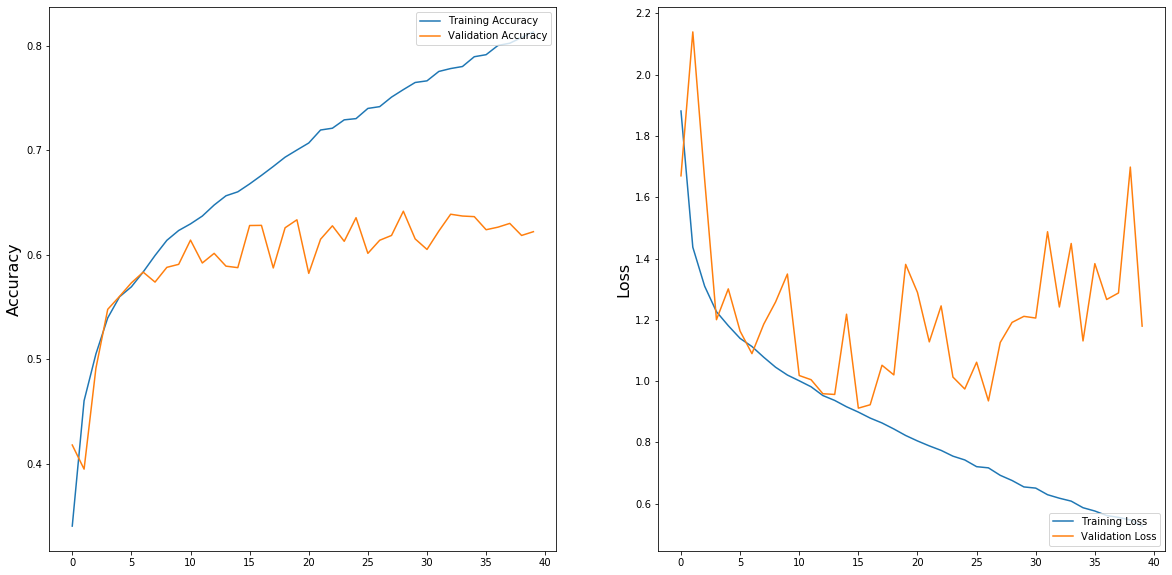

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='lower right')


plt.show()